Train Neural Networks to estimate Likelihood Ratios
===

In this notebook we will setup the neural networks that train unbiased and low-variance density ratios to be then used for inference. The statistical model we have is: 

$$p(x|\mu)$$ 

In [60]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from tensorflow.keras.optimizers import Nadam
import mplhep as hep
import matplotlib.pyplot as plt


In [49]:
saved_data='./cached_data/'

In [50]:
training_features = np.load(f"{saved_data}features.npy")
train_labels = np.load(f"{saved_data}train_labels.npy")
preselection_score = np.load(f"{saved_data}preselection_score.npy")
weights = np.load(f"{saved_data}weights.npy")

In [51]:
preselection_score[train_labels==1].shape

(436311,)

In [52]:
# labels_dict = {"ttbar": 0,
#                "single_top_s_chan":1,
#               "single_top_t_chan":2,
#               "single_top_tW":3,
#               "wjets":4}

# Keep only a subset of the background for illustration
labels_dict = {"ttbar": 0,
              "single_top_t_chan":1,
              "wjets":2}

In [53]:
min_pred = np.amin(preselection_score)
max_pred = np.amax(preselection_score)

bins = np.linspace(min_pred, max_pred, num=150)

hist_NN_output = {}

for key in labels_dict: 
    hist_NN_output[key], _ = np.histogram(preselection_score[train_labels==labels_dict[key]], weights = weights[train_labels==labels_dict[key]], bins=bins)


Make a selection cut for performing the NSBI analysis, balancing the number of signal events that go into the signal region (increasing sensitivity) and the feasibility of training accurate and precise NNs over a large phase space (need bigger models and more statistics).

As a first cut, we choose a loose preselection and see if it works.

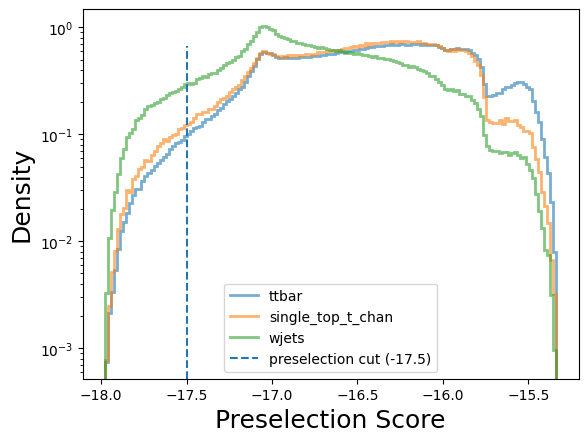

In [54]:
preselection_cut = -17.5 # Lets start with a very loose cut

for key in labels_dict:  
    hep.histplot(hist_NN_output[key], bins=bins, 
             alpha=0.6, label=key, 
             density=True, linewidth=2.0)

plt.xlabel("Preselection Score", size=18)
plt.axvline(preselection_cut, ymax=0.9, linestyle='--', label=f'preselection cut ({preselection_cut})')
plt.ylabel("Density", size=18)
plt.legend()
plt.yscale('log')
plt.show()

In [57]:
# Make the preselections

training_features = training_features[preselection_score>=preselection_cut].copy()
train_labels = train_labels[preselection_score>=preselection_cut].copy()
weights = weights[preselection_score>=preselection_cut].copy()

preselection_score_selected = preselection_score[preselection_score>=preselection_cut].copy()


In [ ]:
class TrainEvaluate_NN:

    def __init__(self, dataset, columns, columns_scaling, 
                rnd_seed, sample_name, output_dir,
                 output_name, path_to_figures='',
                     path_to_models='', path_to_ratios='',
                     use_log_loss=False, split_using_fold=False):

        self.dataset = dataset
        self.columns = columns
        self.columns_scaling = columns_scaling
        self.random_state_holdout = rnd_seed
        self.sample_name = sample_name
        self.output_dir = output_dir
        self.output_name = output_name
        self.path_to_figures = path_to_figures
        self.path_to_models = path_to_models

        self.path_to_ratios=path_to_ratios
        self.use_log_loss = use_log_loss
        self.split_using_fold = split_using_fold
        

    def train(self, hidden_layers, neurons, number_of_epochs, batch_size,
             learning_rate, scalerType, calibration=False, 
             num_bins_cal = 40, callback = True, 
             callback_patience=30, callback_factor=0.01,
             activation='swish'):





def build_model(n_hidden=4, n_neurons=1000, learning_rate=0.1, 
                input_shape=[11], use_log_loss=False, optimizer_choice='Nadam', 
                activation='swish'):
    
    model = tf.keras.models.Sequential()
    options = {"input_shape":input_shape}
    for layer in range(n_hidden):

        if activation=='mish':
            def mish(inputs):
                x = tf.nn.softplus(inputs)
                x = tf.nn.tanh(x)
                x = tf.multiply(x, inputs)
                return x

            model.add(Dense(n_neurons, activation=mish, **options))
        else:
            model.add(Dense(n_neurons, activation=activation, **options))
        options={}

    if not use_log_loss:
        model.add(Dense(1,activation='sigmoid',**options))
    else:
        model.add(Dense(1,activation='linear',**options))

    if optimizer_choice=='Nadam':
        optimizer = tf.keras.optimizers.Nadam(lr=learning_rate) 
    elif optimizer_choice=='Adam':
        optimizer = tf.keras.optimizers.Adam(lr=learning_rate) 

    if use_log_loss:
        model.compile(loss=CARL_mod, optimizer=optimizer,weighted_metrics=['binary_accuracy'])
    else:
        model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=optimizer,weighted_metrics=['binary_accuracy'])
    return model

#The modified CARL loss that directly regresses to LLR
def CARL_mod(s_truth, s_predicted): 

    loss = (s_truth)*tf.exp(-0.5*s_predicted)+(1.0-s_truth)*tf.exp(0.5*s_predicted)

    return loss
